# echopype demonstration notebook 2. Pacific Hake Survey ship data

Jupyter notebook accompanying the manuscript:

A Python library for interoperable and scalable processing of ocean sonar data for biological information
Authors: Wu-Jung Lee, Emilio Mayorga, Landung Setiawan, Kavin Nguyen, Imran Majeed, Valentina Staneva

**Goals**

Illustrate a common workflow for ship-based echosounder data conversion, calibration and use, which leverages the standardization applied by echopype and the power, ease of use and familiarity of the scientific Python ecosystem. Extract and visualize data with relative ease using geospatial and temporal filters. 

**Description**

This notebook uses EK60 echosounder data collected during the [2017 Joint U.S.-Canada Integrated Ecosystem and Pacific Hake Acoustic Trawl Survey ('Pacific Hake Survey')](https://www.fisheries.noaa.gov/west-coast/science-data/joint-us-canada-integrated-ecosystem-and-pacific-hake-acoustic-trawl-survey) to illustrate a common workflow for data conversion, calibration and analysis using [echopype](https://echopype.readthedocs.io) and core scientific Python software packages, particularly `xarray`, `GeoPandas`, `Pandas` and `numpy`. Two days of cloud-based `.raw` data files are accessed by echopype directly from an [Amazon Web Services (AWS)](https://aws.amazon.com/) S3 "bucket" maintained by the [NOAA NCEI Water-Column Sonar Data Archive](https://registry.opendata.aws/ncei-wcsd-archive/). The total data used are 170 `.raw` files at approximately 25 MB each (1 Hz pinging rate from first light to dusk), corresponding to approximately 4.2 GB. With `echopype`, each file is converted to a standardized representation based on the [SONAR-netCDF4 v1.0 convention](https://github.com/ices-publications/SONAR-netCDF4/) and saved to the cloud-optimized [Zarr](https://zarr.readthedocs.io) format. Data stored in the netCDF-based SONAR-netCDF4 convention can be conveniently and intuitively manipulated with `xarray` in combination with related scientific Python packages. Mean Volume Backscattering Strength (MVBS) is computed with `echopype` from each raw data file and exported to a netCDF file. Here, we define two geographical bounding boxes encompassing two ship tracks and use these to extract corresponding timestamp intervals from the GPS data, and then the corresponding MVBS data based on those intervals. Finally, these extracted MVBS subsets are plotted as track echograms.

**Outline**

1. Establish AWS S3 file system connection and generate list of target EK60 `.raw` files
2. Process S3-hosted raw files with echopype: convert, calibrate and export to standardized files
3. Extract and process GPS locations from the `Platform` group of converted raw files
4. Read MVBS and plot track echograms for time periods corresponding to two ship tracks

**Running the notebook.** 

This notebook can be run with a conda environment created using the conda environment file https://github.com/OSOceanAcoustics/echopype-examples/blob/echopype_paper/binder/environment.yml. The notebook creates two directory paths, if not already present: `./exports/hakesurvey_convertednc` and `./exports/hakesurvey_calibratednc`. netCDF and zarr files will be exported there.

In [1]:
from pathlib import Path

import fsspec
import numpy as np
import geopandas as gpd
import xarray as xr

import matplotlib.pyplot as plt
from shapely.geometry import box
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import echopype as ep

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

## Establish AWS S3 file system connection and generate list of target EK60 `.raw` files

Access and inspect the publicly accessible NCEI WCSD S3 bucket on the AWS cloud as if it were a local file system. This will be done through the Python [fsspec](https://filesystem-spec.readthedocs.io) file system and bytes storage interface. We will use `fsspec.filesystem.glob` (`fs.glob`) to generate a list of all EK60 `.raw` data files in the bucket, then filter on file names for target dates of interest. 

The directory path on the [ncei-wcsd-archive S3 bucket](https://ncei-wcsd-archive.s3.amazonaws.com/index.html) is `s3://ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/`. All `.raw` files from the 2017 Hake survey cruise are found here.

In [2]:
fs = fsspec.filesystem('s3', anon=True)

bucket = "ncei-wcsd-archive"
rawdirpath = "data/raw/Bell_M._Shimada/SH1707/EK60"

In [3]:
s3rawfiles = fs.glob(f"{bucket}/{rawdirpath}/*.raw")

# print out the last two S3 raw file paths in the list
s3rawfiles[-2:]

['ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170913-T180733.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Winter2017-D20170615-T002629.raw']

Generate list of target EK60 `.raw` files from AWS S3 bucket based on dates. The dates are found in the middle string token (e.g., "D20170913"). Select files from 2 days, 2017-07-28 and 2017-07-29.

In [4]:
s3rawfiles = [
    s3path for s3path in s3rawfiles 
    if any([f"D2017{datestr}" in s3path for datestr in ['0728', '0729']])
]

print(f"There are {len(s3rawfiles)} target raw files available")

There are 170 target raw files available


## Process S3-hosted raw files with echopype: convert, calibrate and export to standardized files

Loop through all the selected raw files on S3 and convert, calibrate and generate Mean Volume Backscattering Strength (MVBS). Save the raw converted and MVBS data to local files, as zarr and netCDF, respectively.

In [5]:
def populate_metadata(ed, raw_fname):
    """
    Manually populate into the "ed" EchoData object 
    additional metadata about the dataset and the platform
    """
    
    # -- SONAR-netCDF4 Top-level Group attributes
    survey_name = (
        "2017 Joint U.S.-Canada Integrated Ecosystem and "
        "Pacific Hake Acoustic Trawl Survey ('Pacific Hake Survey')"
    )
    ed.top.attrs['title'] = f"{survey_name}, file {raw_fname}"
    ed.top.attrs['summary'] = (
        f"EK60 raw file {raw_fname} from the {survey_name}, converted to a SONAR-netCDF4 file using echopype."
        "Information about the survey program is available at "
        "https://www.fisheries.noaa.gov/west-coast/science-data/"
        "joint-us-canada-integrated-ecosystem-and-pacific-hake-acoustic-trawl-survey"
    )

    # -- SONAR-netCDF4 Platform Group attributes
    # Per SONAR-netCDF4, for platform_type see https://vocab.ices.dk/?ref=311
    ed.platform.attrs['platform_type'] = "Research vessel"
    ed.platform.attrs['platform_name'] = "Bell M. Shimada"  # A NOAA ship
    ed.platform.attrs['platform_code_ICES'] = "315"

Create the directories where the exported files will be saved, if these directories don't already exist.

In [6]:
base_dpath = Path('./exports')
base_dpath.mkdir(exist_ok=True)

converted_dpath = Path(base_dpath / 'hakesurvey_convertednc')
converted_dpath.mkdir(exist_ok=True)
calibrated_dpath = (base_dpath / 'hakesurvey_calibratednc')
calibrated_dpath.mkdir(exist_ok=True)

### echopype processing

(FINALIZE THIS TEXT)
`EchoData` is an echopype object for conveniently handling raw converted data from either raw instrument files or previously converted and standardized raw netCDF and zarr files. It is essentially a container for multiple `xarray` `Dataset` objects, where each such object corresponds to one of the netCDF4 groups specified in the SONAR-netCDF4 convention followed by echopype. It is used for conveniently accessing and exploring the echosounder data and for calibration and other processing.

For each raw file:
- Access file directly from S3 via `ep.open_raw` to create a converted `EchoData` object
- Add global and platform attributes to `EchoData` object
- Export to a local zarr dataset (a collection of files encapsulated in a directory)
- Generate calibrated `Sv` and then `MVBS` from the raw data in the `EchoData` object
- Export `MVBS` to a local netcdf file

In [7]:
%%time

for s3rawfpath in s3rawfiles:
    raw_fpath = Path(s3rawfpath)
    try:
        ed = ep.open_raw(
            f"s3://{s3rawfpath}",
            sonar_model='EK60',
            storage_options={'anon': True}
        )
        # Manually populate additional metadata about the dataset and the platform
        populate_metadata(ed, raw_fpath.name)

        # Save to converted zarr, then use the EchoData object "ed" to generate 
        # calibrated and compute-MVBS files that will be saved to netcdf
        ed.to_zarr(save_path=converted_dpath, overwrite=True)

        # Generate and save MVBS
        ds_Sv = ep.calibrate.compute_Sv(ed)
        ds_MVBS = ep.preprocess.compute_MVBS(
            ds_Sv,
            range_meter_bin=5,  # in meters
            ping_time_bin='20s'  # in seconds
        )
        ds_MVBS.to_netcdf(calibrated_dpath / f"MVBS_{raw_fpath.stem}.nc")
    except Exception as e:
        print(f"Failed to process raw file {raw_fpath.name}: {e}")

11:37:56  parsing file Summer2017-D20170728-T000534.raw, time of first ping: 2017-Jul-28 00:05:34
11:37:59  overwriting /usr/mayorgadat/workmain/acoustics/gh/OSOceanAcoustics/echopype-examples/notebooks/exports/hakesurvey_convertednc/Summer2017-D20170728-T000534.zarr
11:38:01  parsing file Summer2017-D20170728-T002507.raw, time of first ping: 2017-Jul-28 00:25:07
11:38:04  overwriting /usr/mayorgadat/workmain/acoustics/gh/OSOceanAcoustics/echopype-examples/notebooks/exports/hakesurvey_convertednc/Summer2017-D20170728-T002507.zarr
11:38:06  parsing file Summer2017-D20170728-T004438.raw, time of first ping: 2017-Jul-28 00:44:38
11:38:09  overwriting /usr/mayorgadat/workmain/acoustics/gh/OSOceanAcoustics/echopype-examples/notebooks/exports/hakesurvey_convertednc/Summer2017-D20170728-T004438.zarr
11:38:11  parsing file Summer2017-D20170728-T010354.raw, time of first ping: 2017-Jul-28 01:03:54
11:38:13  overwriting /usr/mayorgadat/workmain/acoustics/gh/OSOceanAcoustics/echopype-examples/not

### Test for time reversals

Small time reversals are found in EK60 datasets, including the 2017 Pacific Hake survey, where the `ping_time` (or GPS `location_time`) value may be lower (older) than the preceding `ping_time` by a second. Such discontinuities can interfere with the use of aggregated datasets that concatenate individual raw files. The capability to identify and address these reversals will be released soon in an upcoming version of `echopype`.

In [8]:
for datapath in converted_dpath.glob('*'):
    ed = ep.open_converted(datapath)
    # Test for a negative ping_time increment in sequential timestamps, in the Beam group
    if (np.diff(ed.beam['ping_time']) < np.timedelta64(0, "ns")).any():
        print(f"Reversed time in {datapath}")

There are no time reversals in this two-day dataset, fortunately.

### Examine the EchoData object for one of the data files

echopype provides a user-friendly, convenient representation of an `EchoData` object that leverages the user-friendly `xarray` `Dataset` HTML representation. Since an `EchoData` object is effectively a container for multiple xarray `Dataset` objects corresponding to netCDF4 groups, the notebook "print out" provides a summary view of all the groups and ineractive access to summaries of each of the groups.

Here, `ed` is the last object opened in the time reversal test, in the preceding cell.

In [9]:
ed

EchoData: standardized raw data from exports/hakesurvey_convertednc/Summer2017-D20170728-T032715.zarr
  > top: (Top-level) contains metadata about the SONAR-netCDF4 file format.
  > environment: (Environment) contains information relevant to acoustic propagation through water.
  > platform: (Platform) contains information about the platform on which the sonar is installed.
  > provenance: (Provenance) contains metadata about how the SONAR-netCDF4 version of the data were obtained.
  > sonar: (Sonar) contains specific metadata for the sonar system.
  > beam: (Beam) contains backscatter data and other beam or channel-specific data.
  > vendor: (Vendor specific) contains vendor-specific information about the sonar and the data.

## Extract and process GPS locations from the `Platform` group of converted raw files

Use `xarray.open_mfdataset` to open the `Platform` group from all the converted raw netcdf files as a single concatenated (combined) `xarray` dataset. Then extract GPS `location_time` (time stamp), `latitude` and `longitude` from this group and transform that data into a [GeoPandas](https://geopandas.org/) `GeoDataFrame` containing point-geometry objects that are readily manipulated via geospatial operations. A `GeoDataFrame` adds geospatial capabilities to a Pandas `DataFrame`.

Due to the presence of two time coordinates in this group (`ping_time` and `location_time`), care must be taken in defining how the concatenation (combine) operation is to be performed. This is captured in the arguments passed to `open_mfdataset`.

In [10]:
%%time
platform_ds = xr.open_mfdataset(
    str(converted_dpath / '*.zarr'), group='Platform', 
    engine='zarr',
    concat_dim=["location_time", "ping_time"],
    data_vars='minimal', coords='minimal'
)

CPU times: user 47.9 s, sys: 894 ms, total: 48.8 s
Wall time: 48.7 s


In [11]:
platform_ds

<xarray.Dataset>
Dimensions:        (frequency: 3, location_time: 244846, ping_time: 88959)
Coordinates:
  * location_time  (location_time) datetime64[ns] 2017-07-28T00:05:36.1030000...
  * frequency      (frequency) float64 1.8e+04 3.8e+04 1.2e+05
  * ping_time      (ping_time) datetime64[ns] 2017-07-28T00:05:34.896999936 ....
Data variables:
    heave          (frequency, ping_time) float64 dask.array<chunksize=(3, 534), meta=np.ndarray>
    latitude       (location_time) float64 dask.array<chunksize=(102533,), meta=np.ndarray>
    longitude      (location_time) float64 dask.array<chunksize=(102533,), meta=np.ndarray>
    pitch          (frequency, ping_time) float64 dask.array<chunksize=(3, 534), meta=np.ndarray>
    roll           (frequency, ping_time) float64 dask.array<chunksize=(3, 534), meta=np.ndarray>
    sentence_type  (location_time) object dask.array<chunksize=(102533,), meta=np.ndarray>
    water_level    (frequency, ping_time) float64 dask.array<chunksize=(3, 534), meta=np.ndarray>
Attributes:
    platform_code_ICES:  315
    platform_name:       Bell M. Shimada
    platform_type:       Research vessel

We can use `location_time` (or `ping_time`) to examine the exact timestamp interval spanned by the combined dataset.

In [12]:
print(f"{platform_ds.location_time.values.min()}, {platform_ds.location_time.values.max()}")

2017-07-28T00:05:36.103000064, 2017-07-30T00:17:59.381000192


To create the GeoPandas GeoDataFrame, first transform the `latitude` and `longitude` arrays to a single Pandas DataFrame that retains the `location_time` coordinate as a common index. This is done by using the DataFrame `to_dataframe` method together with a Pandas `join` operation. Then, a point GeoDataFrame is created from this DataFrame.

In [13]:
gps_df = platform_ds.latitude.to_dataframe().join(platform_ds.longitude.to_dataframe())

gps_df.head(3)

,latitude,longitude
location_time,,
2017-07-28 00:05:36.103000064,43.533072,-124.683998
2017-07-28 00:05:37.511000064,43.533080,-124.684005
2017-07-28 00:05:37.669000192,43.533167,-124.684000


In [14]:
gps_gdf = gpd.GeoDataFrame(
    gps_df,
    geometry=gpd.points_from_xy(gps_df['longitude'], gps_df['latitude']), 
    crs="epsg:4326"
)

A simple, easily generated map plot of the point GeoDataFrame

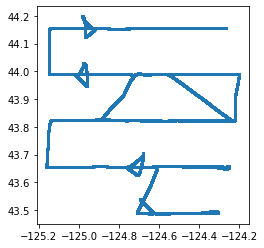

In [15]:
gps_gdf.plot(markersize=2);

## Read MVBS and plot track echograms for time periods corresponding to two ship tracks

### Read MVBS as a concatenated dataset

Use `xarray.open_mfdataset` again to read and concatenate (combine) data files into a single xarray Dataset. This time, we're reading the MVBS netCDF files.

In [16]:
%%time
MVBS_ds = xr.open_mfdataset(
    str(calibrated_dpath / 'MVBS_*.nc'), 
    combine='by_coords'
)

CPU times: user 1.47 s, sys: 23.2 ms, total: 1.49 s
Wall time: 1.51 s


In [17]:
MVBS_ds

<xarray.Dataset>
Dimensions:    (frequency: 3, ping_time: 8819, range: 150)
Coordinates:
  * ping_time  (ping_time) datetime64[ns] 2017-07-28T00:05:20 ... 2017-07-30T...
  * frequency  (frequency) float64 1.8e+04 3.8e+04 1.2e+05
  * range      (range) float64 0.0 5.0 10.0 15.0 ... 730.0 735.0 740.0 745.0
Data variables:
    Sv         (frequency, ping_time, range) float64 dask.array<chunksize=(3, 60, 150), meta=np.ndarray>
Attributes:
    binning_mode:          physical units
    range_meter_interval:  5m
    ping_time_interval:    20s

### Extract MVBS along two N-S tracks selected via geographical bounding boxes

Define rectangular bounding boxes around two tracks oriented North-South, then plot a reference map showing all the GPS points (in red), the two bounding boxes (black), and the OOI mooring location (CE04 Oregon Offshore, yellow star) examined in the accompanying Jupyter notebook.

In [18]:
tracksouth_bbox = gpd.GeoSeries(box(-125.17, 43.65, -125.14, 43.84), crs=gps_gdf.crs)
tracknorth_bbox = gpd.GeoSeries(box(-125.17, 43.98, -125.14, 44.17), crs=gps_gdf.crs)

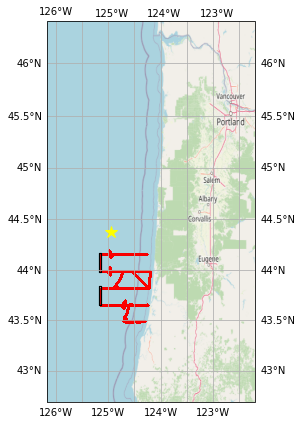

In [19]:
basemap = cimgt.OSM()

_, ax = plt.subplots(
    figsize=(7, 7), subplot_kw={"projection": basemap.crs}
)
bnd = gps_gdf.geometry.bounds
ax.set_extent([bnd.minx.min() - 1, bnd.maxx.max() + 2, 
               bnd.miny.min() - 0.8, bnd.maxy.max() + 2.2])
ax.add_image(basemap, 7)
ax.gridlines(draw_labels=True, xformatter=LONGITUDE_FORMATTER, yformatter=LATITUDE_FORMATTER)

# GPS points
gps_gdf.plot(ax=ax, markersize=0.1, color='red', 
             transform=ccrs.PlateCarree())

# Bounding box for selected tracks
tracksouth_bbox.plot(ax=ax, edgecolor="black", linewidth=1.2, facecolor='none', 
                     transform=ccrs.PlateCarree())
tracknorth_bbox.plot(ax=ax, edgecolor="black", linewidth=1.2, facecolor='none', 
                     transform=ccrs.PlateCarree())

# OOI CE04 Oregon Offshore mooring location
plt.plot(-124.95, 44.37, marker='*', color='yellow', markersize=13, 
         transform=ccrs.PlateCarree());

Clip the GPS locations GeoPandas GeoDataFrame `gps_gdf` generated from the `Platform` group with the two rectangular regions, `tracksouth_bbox` and `tracknorth_bbox`. Extract from those clipped GeoDataFrames (`tracksouth_gps_gdf` and `tracknorth_gps_gdf`) the minimum and maximum `location_time` timestamps for each track; the GeoDataFrame index values correspond to `location_time`. 

Finally, create a MVBS Dataset subset for each track (`tracksouth_MVBS_ds` and `tracknorth_MVBS_ds`) by taking advantage of xarray's "label"-based selection capability via the `sel` method. We select `MVBS_ds` data with `ping_time` values within the timestamp interval "slice" extracted from the geographical track. As we can see above, `ping_time` is a coordinate variable in the `MVBS_ds` Dataset.

In [20]:
tracksouth_gps_gdf = gpd.clip(gps_gdf, tracksouth_bbox)
tracksouth_MVBS_ds = MVBS_ds.sel(
    ping_time=slice(tracksouth_gps_gdf.index.min(), tracksouth_gps_gdf.index.max())
)

tracknorth_gps_gdf = gpd.clip(gps_gdf, tracknorth_bbox)
tracknorth_MVBS_ds = MVBS_ds.sel(
    ping_time=slice(tracknorth_gps_gdf.index.min(), tracknorth_gps_gdf.index.max())
)

### Plot MVBS echograms for the two N-S tracks, for all 3 frequencies

The final step is to create echogram plots (range vs ping_time) for each echosounder frequency and each of the two selected ship tracks. That's 6 subplots. We first define two functions to simplify the task. `plot_echograms` plots the echograms of the 3 frequencies as a column of subplots, extracting the data for each frequency by using xarray's `isel` index selector method, which uses index counts rather than values. As we can see above, `frequency` is a coordinate of the `Sv` (MVBS) DataArray.

In [21]:
def track_interval_str(trackdt):
    """ Create the timestamp interval title string for a plot column
    """
    track_interval_title_str = (
        f"{trackdt.index.min().strftime('%b-%d %H:%MZ')}"
        f" to {trackdt.index.max().strftime('%b-%d %H:%MZ')}"
    )
    return track_interval_title_str

def plot_echograms(ds, freq_len, column_idx):
    """Plot echograms of the 3 frequencies for xarray dataset ds,
       as a column of subplots"""
    for f in range(freq_len):
        ax = axes[f][column_idx]
        # Select Sv data by frequency using the frequency coordinate index "f",
        # then plot the echogram of the selected data
        ds.Sv.isel(frequency=f).plot(
            ax=ax, 
            x='ping_time',
            y='range',
            yincrease=False,
            vmin=-80,
            vmax=-50,
        )
        if f < 2:
            ax.set_xlabel(None)
        ax.set_ylabel('range (meters)');

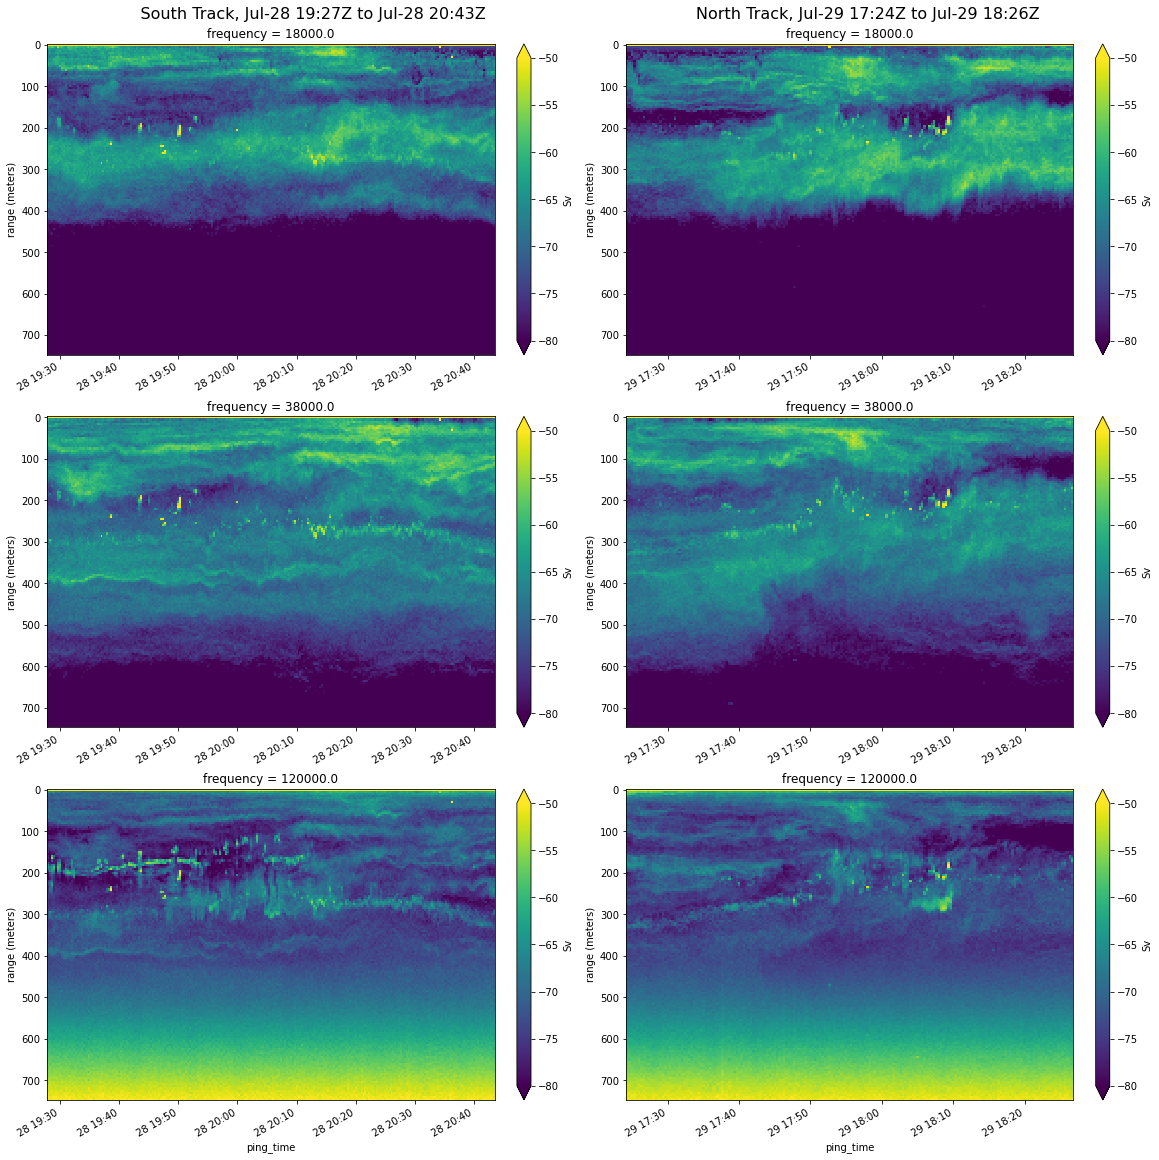

In [24]:
freq_len = len(MVBS_ds.frequency)

fig, axes = plt.subplots(nrows=freq_len, ncols=2, constrained_layout=True, figsize=(16, 16))

fig.suptitle(
    (f"    South Track, {track_interval_str(tracksouth_gps_gdf)}"
     "                                         "
     f"North Track, {track_interval_str(tracknorth_gps_gdf)}"),
    fontsize=16)

plot_echograms(tracksouth_MVBS_ds, freq_len, column_idx=0) # left column
plot_echograms(tracknorth_MVBS_ds, freq_len, column_idx=1) # right column

## Package versions

In [25]:
print(f"echopype: {ep.__version__}, xarray: {xr.__version__}, geopandas: {gpd.__version__}, fsspec: {fsspec.__version__}")

echopype: 0.5.0, xarray: 0.16.2, geopandas: 0.9.0, fsspec: 0.8.7


In [26]:
import datetime
print(f"{datetime.datetime.utcnow()} +00:00")

2021-07-11 19:29:26.263559 +00:00
